# Исследовательский анализ работы ChatGPT в роли помощника по классификации номенклатуры

В конфигурации 1С:ERP реализован следующий функционал - на этапе формирования заявки на создание номенклатурной позиции в службу НСИ подключено 2 сервиса:
- подбор конечного класса на базе описания номеклатурной позиции
- подбор значений для набора атрибутов конечного класса на базе описания номеклатурной позиции

Классы и атрибуты живут в корпоративном классификаторе. Сервисы реализованы на базе OpenAI ChatGPT

Параллельно с этим функционалом в 1С:ERP реализован сбор статистики по работе этих сервисов

В этом исследовании рассмотрим, насколько эффективно помогает пользователям в формировании заявок данное решение

## Загрузка и обзор данных

In [581]:
#импортируем все используемые библиотеки в проекте
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "png"

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', 50)

Выгружено 2 датасета:
- `df_cls` содержит статистику работы сервиса по подбору конечного класса
- `df_att` содержит статистику работы сервиса по подбору значений для набора атрибутов

В эти выгрузки попали только те заявки, в которых пользователи полноценно поработали с ChatGPT помощником от начала до конца оформления

In [583]:
df_cls = pd.read_excel('classify_stat.xlsx')
df_att = pd.read_excel('pickAtt_stat.xlsx')

**`df_cls` подбор конечного класса**

In [585]:
df_cls = df_cls.rename(columns={'Период':'date',
                                'Пользователь': 'user',
                                'УИД заявки': 'uid_purchase',
                                'Описание': 'item_name',
                                'Класс GPT': 'class_gpt',
                                'Класс пользователя': 'class_user'})
df_cls = df_cls[['date', 'user', 'uid_purchase', 'item_name', 'class_gpt', 'class_user']]
display(df_cls.head(5))
df_cls.info()

,date,user,uid_purchase,item_name,class_gpt,class_user
0,05.11.2024 11:35:32,user1,a25b7682-ff0a-4ebe-9557-59dde0194fbb,Сетка 4Ср 5Вр1-100 гост 23279-2012,Металлоизделия прочие,Металлоизделия прочие
1,05.11.2024 13:15:09,user2,96612021-77cc-4228-8334-68cbab0b9605,Труба 159х12 сталь 12Х18Н10Т ГОСТ 9941·-81,Трубы стальные б/ш х/д нерж. по ГОСТ 9941,Трубы стальные б/ш х/д нерж. по ГОСТ 9941
2,05.11.2024 14:51:36,user3,918c0964-f814-4b63-aea8-a60a7b721d59,Расходомер ультразвуковой ИПС/2016-001-Р-2-02-...,Расходомеры акустические,Расходомеры акустические
3,06.11.2024 8:47:11,user4,fe124eab-66b9-4900-b96f-3c9bc660f6f8,"Стеклопластик РСТ-250Л (толщ.0,25 мм, шир.1000...",Стеклопластики рулонные,Стеклопластики рулонные
4,06.11.2024 10:24:24,user3,f62ad8a6-3f05-45eb-b06c-3b27ba6066e8,Сигнализация верхнего предельного уровня в\nре...,"Сигнализаторы уров.(по пределам измер,м)","Сигнализаторы уров.(по пределам измер,м)"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          288 non-null    object
 1   user          288 non-null    object
 2   uid_purchase  288 non-null    object
 3   item_name     288 non-null    object
 4   class_gpt     288 non-null    object
 5   class_user    288 non-null    object
dtypes: object(6)
memory usage: 13.6+ KB


**`df_att` подбор значений для набора атрибутов**

In [587]:
df_att = df_att.rename(columns={'Период':'date',
                                'Пользователь': 'user',
                                'УИД заявки': 'uid_purchase',
                                'УИДАтрибута': 'uid_att',
                                'Представление атрибута': 'name_att',
                                'Значение GTP': 'value_gpt',
                                'Значение пользователя': 'value_user'})
df_att = df_att[['date', 'user', 'uid_purchase', 'uid_att', 'name_att', 'value_gpt', 'value_user']]
display(df_att.head(5))
df_att.info()

,date,user,uid_purchase,uid_att,name_att,value_gpt,value_user
0,05.11.2024 11:35:32,user1,a25b7682-ff0a-4ebe-9557-59dde0194fbb,b9aa0af6-339f-11ef-b029-00155d13bf04,Вид продукции,Сетка,Сетка
1,05.11.2024 11:35:32,user1,a25b7682-ff0a-4ebe-9557-59dde0194fbb,b9aa0af7-339f-11ef-b029-00155d13bf04,"Ширина, мм",NaN,100
2,05.11.2024 11:35:32,user1,a25b7682-ff0a-4ebe-9557-59dde0194fbb,b9aa0af8-339f-11ef-b029-00155d13bf04,"Длина, мм",NaN,100
3,05.11.2024 11:35:32,user1,a25b7682-ff0a-4ebe-9557-59dde0194fbb,b9aa0af9-339f-11ef-b029-00155d13bf04,Назначение,NaN,для бетона
4,05.11.2024 13:15:09,user2,96612021-77cc-4228-8334-68cbab0b9605,b9aa090f-339f-11ef-b029-00155d13bf04,Вид продукции,Труба,Труба стальная


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          2372 non-null   object
 1   user          2359 non-null   object
 2   uid_purchase  2372 non-null   object
 3   uid_att       2372 non-null   object
 4   name_att      2372 non-null   object
 5   value_gpt     1372 non-null   object
 6   value_user    2091 non-null   object
dtypes: object(7)
memory usage: 129.8+ KB


**Cтруктура**
- `date`: дата заявки
- `user`: имя пользователя
- `uid_purchase`: айди заявки
- `item_name`: наименование номенклатуры
- `class_gpt`: класс, который подобран gpt
- `class_user`: класс, который подобран пользователем
- `uid_att`: айди атрибута
- `name_att`: наименование атрибута
- `value_gpt`: значение атрибута, которое подобрано gpt
- `value_user`: значение атрибута, которое подобрано пользователем

## Подготовока данных

**Поправим тип данных для дат**

In [591]:
df_cls['date'] = pd.to_datetime(df_cls['date'], format='%d.%m.%Y %H:%M:%S')
df_att['date'] = pd.to_datetime(df_att['date'], format='%d.%m.%Y %H:%M:%S')

**Проверим дубли**

In [593]:
df_cls[['uid_purchase', 'date']].duplicated().sum()

0

In [594]:
df_att[['uid_purchase', 'uid_att', 'date']].duplicated().sum()

0

ok

**Добавление новых столбцов**

Добавим признак совпадения, который отражает, что подобранное значение gpt совпало со значением пользователя

In [598]:
df_cls['equal'] = df_cls['class_gpt'] == df_cls['class_user']

In [599]:
#все значения атрибутов приведем в нижний регистр и уберем все пробелы для более корректного сравнения
df_att['value_gpt'] = df_att['value_gpt'].str.casefold()
df_att['value_gpt'] = df_att['value_gpt'].str.replace(' ', '')
df_att['value_user'] = df_att['value_user'].str.casefold()
df_att['value_user'] = df_att['value_user'].str.replace(' ', '')

df_att['equal'] = df_att['value_gpt'] == df_att['value_user']

## Исследовательский анализ

Рассмотрим за какой период пресдтавлены данные

In [602]:
print('Периоды')

max_dt = df_cls['date'].max()
min_dt = df_cls['date'].min()
print(f'Классы:\n{min_dt} - {max_dt}')

max_dt = df_att['date'].max()
min_dt = df_att['date'].min()
print(f'Атрибуты:\n{min_dt} - {max_dt}')

Периоды
Классы:
2024-11-05 11:35:32 - 2024-12-06 11:09:52
Атрибуты:
2024-11-05 11:35:32 - 2024-12-06 11:09:52


**Расмматриваемый период - с 5 ноября по 6 декабря 2024 (1 месяц)**

### Статистика по подбору конечного класса

In [605]:
def show_barplots(data_input, category, agg_dct, title, x_title, sorting, show_prop):
    grpd =(data_input.
           groupby(category).
           agg(agg_dct).
           sort_values(by='equal').
           reset_index())
    
    count_column = list(agg_dct.keys())[0]
    
    fig = px.bar(grpd,
                 x=category[0],
                 y=count_column,
                 color='equal',
                 text_auto='3',
                 color_discrete_sequence=px.colors.qualitative.T10)

    fig.update_layout(title=title,
                      xaxis_title=x_title,
                      yaxis_title='количество (шт)',
                      xaxis=dict(tickangle=45),
                      autosize=False,
                      width=870,
                      height=600)
    if sorting:
        fig.update_xaxes(categoryorder='total descending')
    
    fig.update_traces(textfont_size=12, textangle=0, textposition='outside', cliponaxis=False)

    fig.show()
    
    if show_prop:
        sum_count = grpd.loc[0][count_column] + grpd.loc[1][count_column]
        prop = round((grpd.loc[1][count_column] / sum_count)*100, 2)

        print(f'всего: {sum_count}')
        print(f'true / false: {prop} %')

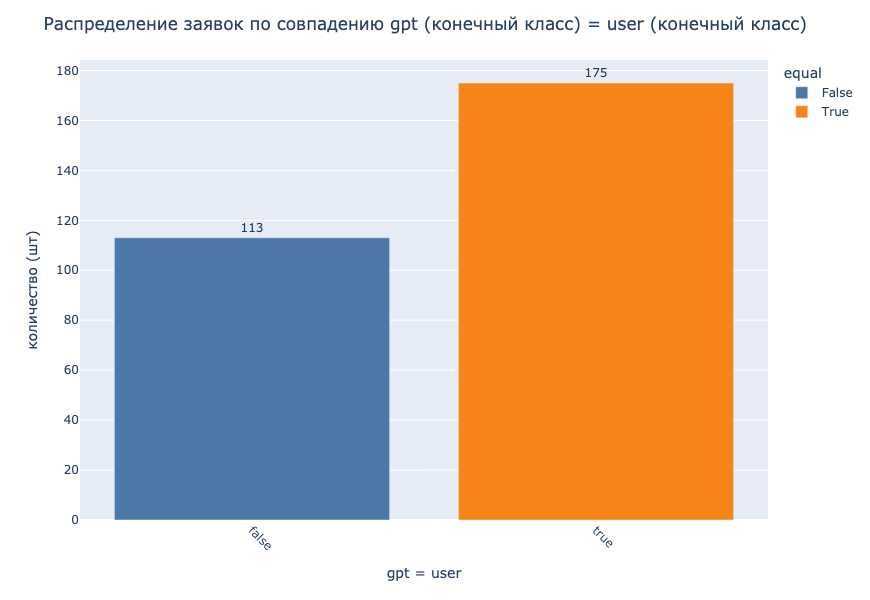

всего: 288
true / false: 60.76 %


In [606]:
show_barplots(df_cls,
              ['equal'],
              {'uid_purchase':'count'},
              'Распределение заявок по совпадению gpt (конечный класс) = user (конечный класс)',
              'gpt = user',
              False,
              True)

То есть в 60 случаев из 100 пользователь не меняет класс, который подобрал gpt

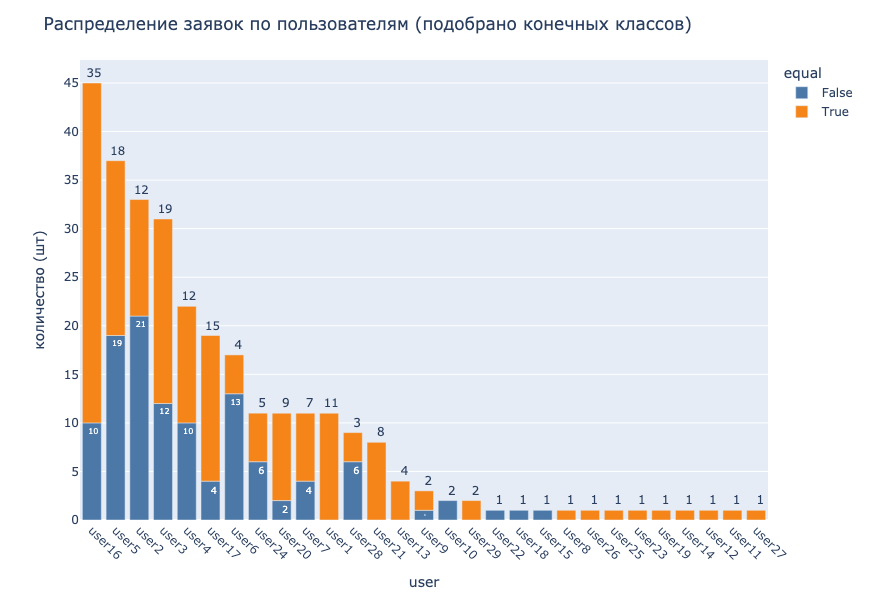

In [608]:
show_barplots(df_cls,
              ['user', 'equal'],
              {'uid_purchase':'count'},
              'Распределение заявок по пользователям (подобрано конечных классов)',
              'user',
              True,
              False)

Активность по пользователям сервиса подбора конечного класса

### Статистика по подбору атрибутов

Не будем брать в расчет те атрибуты, значения к которым gpt не подобрал и оставил null

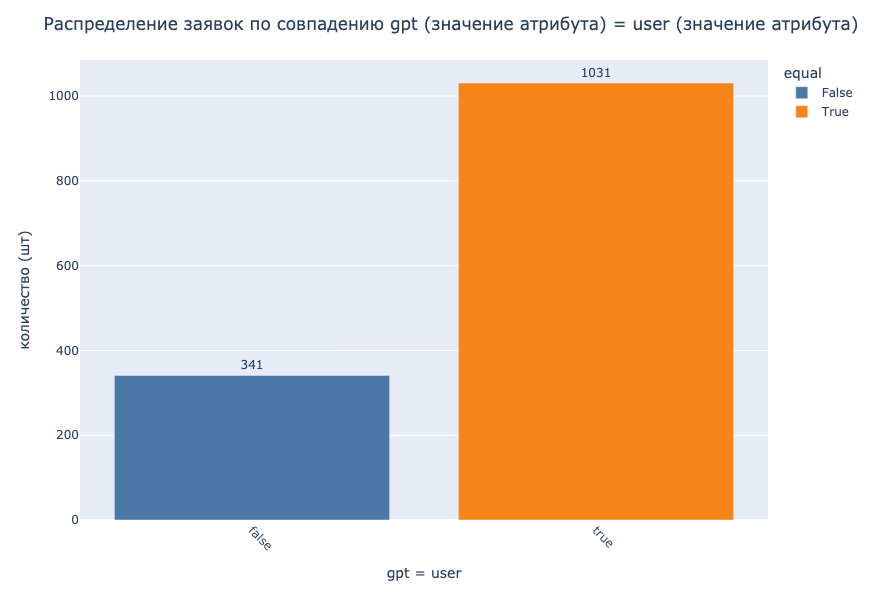

всего: 1372
true / false: 75.15 %


In [612]:
show_barplots(df_att[df_att['value_gpt'].notna()],
              ['equal'],
              {'uid_att':'count'},
              'Распределение заявок по совпадению gpt (значение атрибута) = user (значение атрибута)',
              'gpt = user',
              False,
              True)

То есть в 75 случаев из 100 пользователь не меняет атрибут, который смог подобрать gpt

Теперь включим в расчет атрибуты с null

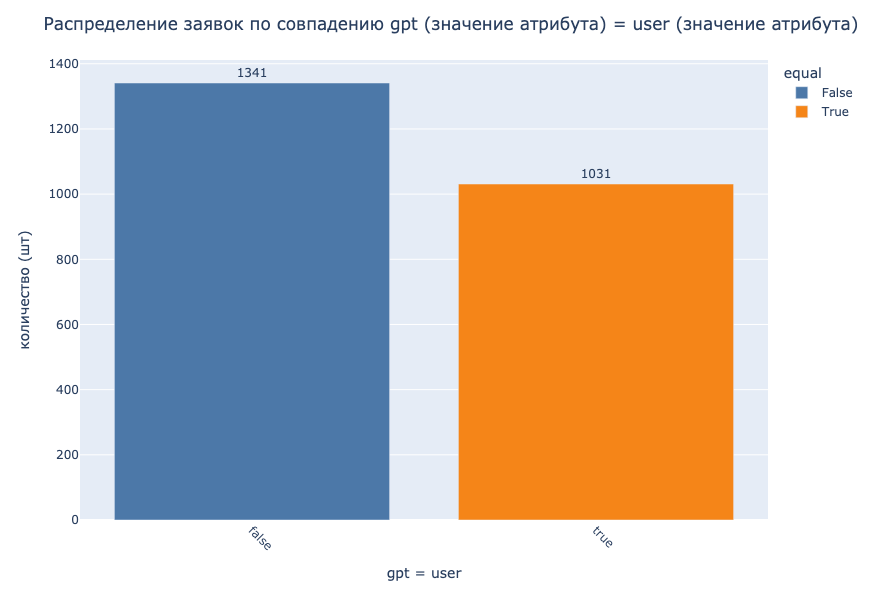

всего: 2372
true / false: 43.47 %


In [615]:
show_barplots(df_att,
              ['equal'],
              {'uid_att':'count'},
              'Распределение заявок по совпадению gpt (значение атрибута) = user (значение атрибута)',
              'gpt = user',
              False,
              True)

Процент стал ниже, поскольку пользователь заполнил атрибут, где gpt оставил null

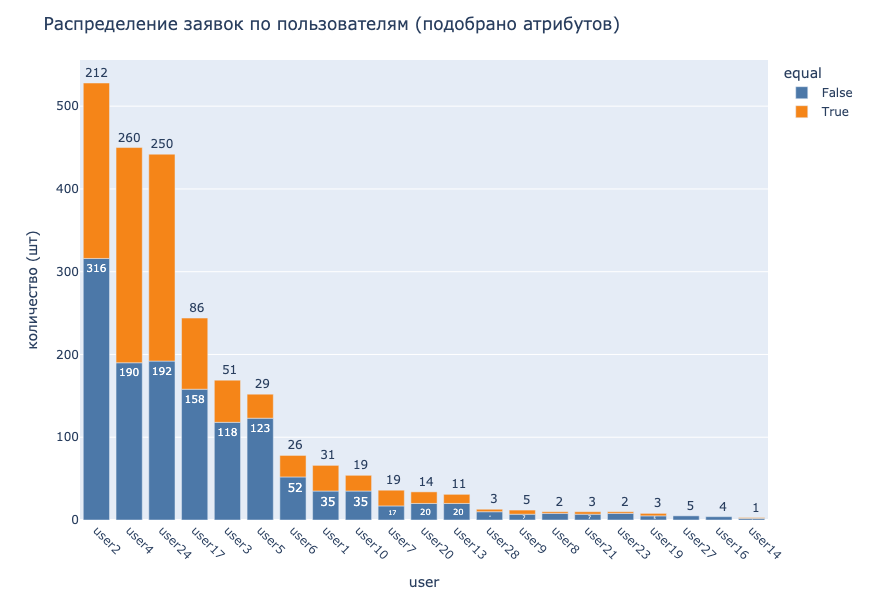

In [617]:
show_barplots(df_att,
              ['user','equal'],
              {'uid_att':'count'},
              'Распределение заявок по пользователям (подобрано атрибутов)',
              'user',
              True,
              False)

Активность по пользователям сервиса подбора атрибутов

## Выводы

Учитывая следующие пункты:
- решение призвано помогать в оформлении заявки на создание номенклатурной позиции в службу НСИ
- эффективность ~60% (конечный класс): более чем в половине случаев пользователь не меняет класс, который подобран ChatGPT
- эффективность ~44% (атрибуты): в ~половине случаев пользователь не меняет значение атрибута, который подобран ChatGPT (учитывая значения, которые GPT не заполнил - это связано либо с отсутствием атрибута в описании номенклатуры, либо с неуверенностью ChatGPT). Так как атрибутов много (на один класс может приходится более 20 шт) это можно считать хорошим показателем

Качество работы решения в целом можно оценить позитивно